# [Catch](https://gist.github.com/EderSantana/c7222daa328f0e885093)

In [1]:
from IPython.display import HTML
import numpy as np
import tensorflow as tf
# from keras.models import Sequential
# from keras.layers.core import Dense
# from keras.optimizers import sgd

## Setup Environment

In [ ]:
class Catch(object): # 1 game is 1 fruit dropped from somewhere to bottom
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.basketSize = 0 # actually this is 2*basket_size+1
        self.reset()
        
    def reset(self):
        n = np.random.randint(0, self.grid_size-1)         # fruit_row at start (0 is top)
        m = np.random.randint(1, self.grid_size-2)         # fruit_col at start
        self.state = np.asarray([0, n, m])[np.newaxis]     # [basket location from left, fruit_row, fruit_col]
        
    def _update_state(self, action):
        """Input action and states., output new states and reward """
        state = self.state
        if action == 0:   action = -1 # move left
        elif action == 1: action =  0 # stay
        else:             action =  1 # move right
        f0, f1, basket = state[0]
        new_basket = min(max(self.basketSize, basket + action), self.grid_size-self.basketSize)
        f0 += 1                       # fruit dropped by one pixel
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]
        assert len(out.shape) == 2
        self.state = out
        
    def _draw_state(self):
        im_size = (self.grid_size, self.grid_size)
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1           # draw fruit
        canvas[-1, state[2]-self.basketSize:state[2] + self.basketSize+1] = 1  # draw basket
        return canvas
    
    def _get_reward(self):   # inc/dec score only if fruit has dropped to bottom
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            return 1 if abs(fruit_col - basket) <= self.basketSize else -1
        else:
            return 0
#         return 1 if abs(fruit_col - basket) <= 1 and fruit_row == self.grid_size-1 else -abs(fruit_col - basket)

    def _is_over(self):    # game over if fruit dropped to bottom
        return (self.state[0, 0] == self.grid_size-1)
    
    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    
    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over # returns whole canvas

* Store all intermediate states 
* after each step, train a random batch from memory
* train target are the Q-values computed from current Q_tables predicted my the current model (`model.predict(state)`)

In [15]:
class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount
        
    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?],
        # state is the full canvas; action=0,1,2 [move_left, stay, move_right]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]
            
    def get_batch(self, model, batch_size=10):   # returns: X: state s (whole canvas); y: Q(s,a) for all a
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]      #number of possible actions
        n_pixels = self.memory[0][0][0].shape[1]  #canvas size
        inputs = np.zeros((min(len_memory, batch_size), n_pixels))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])): # random pick from memory with repetitions
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]
            inputs[i:i+1] = state_t
            targets[i] = model.predict(state_t)[0]    # no target values for actions not taken.
            Q_sa = np.max(model.predict(state_tp1)[0])# max among 3 rewards (corr 3 actions) 
            if game_over:  # Q-learning algorithm (update learning rate handled by optimizer)
                targets[i, action_t] = reward_t
            else: # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets  #(batch_size, n_pixels), (batch_size, num_actions)

## Deep Model

In [ ]:
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epochs = 1000
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10

model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'),
            tf.keras.layers.Dense(hidden_size, activation='relu'),
            tf.keras.layers.Dense(num_actions),
        ])
model.compile(tf.keras.optimizers.Adam(), "mse")

In [19]:
env = Catch(grid_size)
exp_replay = ExperienceReplay(max_memory=max_memory)

win_cnt = 0
for e in range(epochs):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()  #current canvas

    while not game_over:
        input_tm1 = input_t                         # previous canvas
        if np.random.rand() <= epsilon:             # exploration
            action = np.random.randint(0, num_actions, size=1)
        else:
            q = model.predict(input_tm1)
            action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)  # after action: current canvas, reward received, game over flag 
        if reward == 1: win_cnt += 1
            
        exp_replay.remember([input_tm1, action, reward, input_t],  # canvas before action, action taken, reward received, canvas after action
                            game_over)
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        loss += model.train_on_batch(inputs, targets)
        
    if e%(epochs/10)==0:
        print(f"Epoch {e:05d} | Loss {loss:.4f} | Win rate {win_cnt/(epochs/10.):.3f}")
        win_cnt=0

# model.save_weights("model.h5", overwrite=True)

Epoch 00000 | Loss 0.0097 | Win rate 0.000
Epoch 00100 | Loss 0.0277 | Win rate 0.140
Epoch 00200 | Loss 0.0360 | Win rate 0.350
Epoch 00300 | Loss 0.0177 | Win rate 0.600
Epoch 00400 | Loss 0.0081 | Win rate 0.690
Epoch 00500 | Loss 0.0014 | Win rate 0.800
Epoch 00600 | Loss 0.0108 | Win rate 0.770
Epoch 00700 | Loss 0.0080 | Win rate 0.840
Epoch 00800 | Loss 0.0008 | Win rate 0.790
Epoch 00900 | Loss 0.0153 | Win rate 0.830


## Evaluation

In [22]:
win_cnt = 0.
epochs = 10
for e in range(epochs):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()  #current canvas

    while not game_over:
        input_tm1 = input_t
        q = model.predict(input_tm1)
        action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)
        if reward == 1: win_cnt += 1
            
        exp_replay.remember([input_tm1, action, reward, input_t], game_over)
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        loss += model.train_on_batch(inputs, targets)
        
print(f"Epoch {e:05d} | Loss {loss:.4f} | Win rate {win_cnt/epochs:.3f}")

Epoch 00009 | Loss 0.0002 | Win rate 10.000


## Visualization

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
frames = []

for e in range(100):
    loss = 0.
    env.reset()
    game_over = False
    input_t = env.observe()
    frames.append(input_t.reshape((grid_size,)*2))
    while not game_over:
        input_tm1 = input_t
        q = model.predict(input_tm1)
        action = np.argmax(q[0])
        input_t, reward, game_over = env.act(action)
        frames.append(input_t.reshape((grid_size,)*2))
# plt.imshow(frames[9],interpolation='none', cmap='gray')

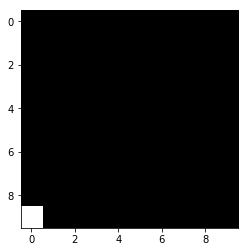

In [24]:
#animation
fig, ax = plt.subplots()
im  = ax.imshow(np.random.random((grid_size,)*2),interpolation='none', cmap='gray')
def init():
#     im.set_array(np.random.random((grid_size,grid_size)))
    return (im,)
def animate(i):
    im.set_array(frames[i])
    return (im,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(frames), interval=50, blit=True)
HTML(anim.to_html5_video())

In [ ]:
#save to files
for i in range(len(frames)):
    plt.imshow(frames[i],interpolation='none', cmap='gray')
    plt.savefig("%03d.png" % i)

# Player, Food, Enemy

https://pythonprogramming.net/own-environment-q-learning-reinforcement-learning-python-tutorial/

on #0, epsilon is 0.9
3000 ep mean: nan


/home/hoi/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hoi/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #3000, epsilon is 0.49390083359356435
3000 ep mean: -166.048
on #6000, epsilon is 0.27104225936046566
3000 ep mean: -114.168
on #9000, epsilon is 0.14874221981913022
3000 ep mean: -83.35
on #12000, epsilon is 0.08162656262136181
3000 ep mean: -69.02466666666666
on #15000, epsilon is 0.044794919246742226
3000 ep mean: -54.165
on #18000, epsilon is 0.024582497729691496
3000 ep mean: -50.09866666666667
on #21000, epsilon is 0.01349035124500733
3000 ep mean: -42.812
on #24000, epsilon is 0.0074032174726434705
3000 ep mean: -35.665


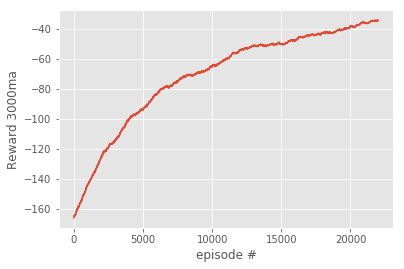

In [25]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

style.use("ggplot")

SIZE = 10

HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 3000  # how often to play through env visually.

start_q_table = None # None or Filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict!
d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}


class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1


if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)


# can look up from Q-table with: print(q_table[((-9, -2), (3, 9))]) for example

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        #print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)